# Task #4: Smoothing the noisy data
## Section 8. Plot the global cases and per continent
#### 8.1 Import necessary packages and functions.

In [1]:
# Data from here:
# https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter

import glob
import os

#### 8.2 Read the master table with the cumulative cases.

In [2]:
# READ, RENAME
covid = pd.read_excel("COVID-19-geographic-disbtribution-worldwide-2020-08-27.xlsx")
# REPLACED WITH THE CODE BELOW THAT EXTRACTS THE LATEST .xlsx FILE IN THE FOLDER

# list_of_files = glob.glob('C:\\Users\\nikan\\Desktop\\COVID_daily/*xlsx') # * means all if need specific format then *.csv
# latest_file = max(list_of_files, key=os.path.getctime)
# print(latest_file)
# covid = pd.read_excel(latest_file) 

covid.rename(columns = {'dateRep': 'DateRep', 'day':'Day', 'month':'Month','year':'Year','cases':'Cases','deaths':'Deaths', 'popData2019':'Population', 'countriesAndTerritories': 'Country', 'continentExp':'Continent'}, inplace = True)

#### 8.3 Perform the groupby aggregation to sum the ’Cases’ and ’Deaths’ over Date and Continent (notice that here we use the original data, not the cumulative).

In [3]:
covid_daily_per_continent = covid.groupby(['DateRep','Continent'])[['Cases', 'Deaths']].sum()
covid_daily_per_continent

Cases  Deaths
DateRep    Continent                
2019-12-31 Africa          0       0
           America         0       0
           Asia           27       0
           Europe          0       0
           Oceania         0       0
...                      ...     ...
2020-08-27 Africa       8870     321
           America    132035    3953
           Asia       103082    1597
           Europe      23931     394
           Oceania       338      24

[1269 rows x 2 columns]

#### 8.4 Generate the cumulative sum of Cases and Deaths per Continent.

In [4]:
covid_daily_per_continent_cumulative = covid_daily_per_continent.groupby(['Continent']).cumsum()
covid_daily_per_continent.reset_index(inplace=True)
covid_daily_per_continent_cumulative.reset_index(inplace=True)
covid_daily_per_continent_cumulative

,DateRep,Continent,Cases,Deaths
0,2019-12-31,Africa,0,0
1,2019-12-31,America,0,0
2,2019-12-31,Asia,27,0
3,2019-12-31,Europe,0,0
4,2019-12-31,Oceania,0,0
...,...,...,...,...
1264,2020-08-27,Africa,1212699,28609
1265,2020-08-27,America,12910547,455566
1266,2020-08-27,Asia,6529270,133503
1267,2020-08-27,Europe,3522921,207818


#### 8.5 Generate the global sum aggregation.

In [5]:
covid_daily_global = covid.groupby(['DateRep'])[['Cases', 'Deaths']].sum()
covid_daily_global.reset_index(inplace=True)
covid_daily_global

,DateRep,Cases,Deaths
0,2019-12-31,27,0
1,2020-01-01,0,0
2,2020-01-02,0,0
3,2020-01-03,17,0
4,2020-01-04,0,0
...,...,...,...
236,2020-08-23,266465,5633
237,2020-08-24,224497,3322
238,2020-08-25,220357,4538
239,2020-08-26,254705,6374


#### 8.6 Generate the cumulative sum at the global level.

In [6]:
covid_daily_global_cumulative = covid.groupby(['DateRep'])[['Cases', 'Deaths']].sum().cumsum()
covid_daily_global_cumulative.reset_index(inplace=True)
covid_daily_global_cumulative

,DateRep,Cases,Deaths
0,2019-12-31,27,0
1,2020-01-01,27,0
2,2020-01-02,27,0
3,2020-01-03,44,0
4,2020-01-04,44,0
...,...,...,...
236,2020-08-23,23236871,805567
237,2020-08-24,23461368,808889
238,2020-08-25,23681725,813427
239,2020-08-26,23936430,819801


#### 8.7 Define two functions to convert values of millions and thousands to M and k format, respectively. E.g. 1,000,000 will be represented in the graph as 1M and 1,000 as 1k.

In [7]:
# TO CONVERT THE MILLIONS IN THE Y-AXIS TO 1M, 2M, etc
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM' % (x * 1e-6)
formatter_mil = FuncFormatter(millions)

# TO CONVERT THE THOUSANDS IN THE Y-AXIS TO 1K, 2K, etc
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fk' % (x * 1e-3)
formatter_kil = FuncFormatter(thousands)

#### 8.8 Configure the x-axis ticks format. Here, we want to show the months instead of Day from 100 cases. The format specified here takes care of that.

In [8]:
# TO PLOT MTH IN THE X-AXIS
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

#### 8.9 Create the data frame with the values on the last day. This will be helpful to annotate the graphs. Also, generate the list of the continents.


In [9]:
last_day_covid = covid_daily_per_continent[covid_daily_per_continent['DateRep'] == covid_daily_per_continent['DateRep'].max()]
last_day_covid_cumulative = covid_daily_per_continent_cumulative[covid_daily_per_continent_cumulative['DateRep'] == covid_daily_per_continent_cumulative['DateRep'].max()]
continents = last_day_covid['Continent'].to_list()

### Generate the 2×2 subplots of the daily and cumulative cases for continents and globally.

#### smoothed daily cases for continents

In [16]:
pd.options.mode.chained_assignment = None 
smoothed_daily_cases = pd.DataFrame(columns=['DateRep','Cases','Deaths','Moving_ave_cases','Moving_ave_deaths','Continent'])

for i in range(len(continents)):
    daily_continent = covid_daily_per_continent[covid_daily_per_continent['Continent'] == str(continents[i])]
    daily_continent['Moving_ave_cases'] = daily_continent['Cases'].rolling(7).mean()
    daily_continent['Moving_ave_deaths'] = daily_continent['Deaths'].rolling(7).mean()
    temp = daily_continent[['DateRep', 'Cases', 'Deaths','Moving_ave_cases','Moving_ave_deaths','Continent']]
    smoothed_daily_cases = pd.concat([smoothed_daily_cases, temp])

,DateRep,Cases,Deaths,Moving_ave_cases,Moving_ave_deaths,Continent
0,2019-12-31 00:00:00,0,0,NaN,NaN,Africa
6,2020-01-01 00:00:00,0,0,NaN,NaN,Africa
12,2020-01-02 00:00:00,0,0,NaN,NaN,Africa
18,2020-01-03 00:00:00,0,0,NaN,NaN,Africa
24,2020-01-04 00:00:00,0,0,NaN,NaN,Africa
...,...,...,...,...,...,...
1248,2020-08-23 00:00:00,251,13,298.428571,15.571429,Oceania
1253,2020-08-24 00:00:00,258,17,280.571429,15.571429,Oceania
1258,2020-08-25 00:00:00,272,15,265.714286,14.142857,Oceania
1263,2020-08-26 00:00:00,237,10,268.714286,13.142857,Oceania


#### smoothed daily cases globally

In [19]:
covid_daily_global['Moving_ave_cases']=covid_daily_global['Cases'].rolling(7).mean()
covid_daily_global['Moving_ave_deaths']=covid_daily_global['Deaths'].rolling(7).mean()

#### smoothed cumulative cases for continents 

In [22]:
smoothed_cum_cases=pd.DataFrame(columns=['DateRep','Cases','Deaths','Moving_ave_cases','Moving_ave_deaths','Continent'])

for i in range(len(continents)):
    cum_continent = covid_daily_per_continent_cumulative[covid_daily_per_continent_cumulative['Continent'] == str(continents[i])]
    cum_continent['Moving_ave_cases'] = cum_continent['Cases'].rolling(7).mean()
    cum_continent['Moving_ave_deaths'] = cum_continent['Deaths'].rolling(7).mean()
    temp = cum_continent[['DateRep','Cases','Deaths','Moving_ave_cases','Moving_ave_deaths','Continent']]
    smoothed_cum_cases = pd.concat([smoothed_cum_cases, temp])

,DateRep,Cases,Deaths,Moving_ave_cases,Moving_ave_deaths,Continent
0,2019-12-31 00:00:00,0,0,NaN,NaN,Africa
6,2020-01-01 00:00:00,0,0,NaN,NaN,Africa
12,2020-01-02 00:00:00,0,0,NaN,NaN,Africa
18,2020-01-03 00:00:00,0,0,NaN,NaN,Africa
24,2020-01-04 00:00:00,0,0,NaN,NaN,Africa
...,...,...,...,...,...,...
1248,2020-08-23 00:00:00,27448,521,26626.285714,480.571429,Oceania
1253,2020-08-24 00:00:00,27706,538,26906.857143,496.142857,Oceania
1258,2020-08-25 00:00:00,27978,553,27172.571429,510.285714,Oceania
1263,2020-08-26 00:00:00,28215,563,27441.285714,523.428571,Oceania


#### smoothed cumulative cases globally

In [25]:
covid_daily_global_cumulative['Moving_ave_cases']=covid_daily_global_cumulative['Cases'].rolling(7).mean()
covid_daily_global_cumulative['Moving_ave_deaths']=covid_daily_global_cumulative['Deaths'].rolling(7).mean()

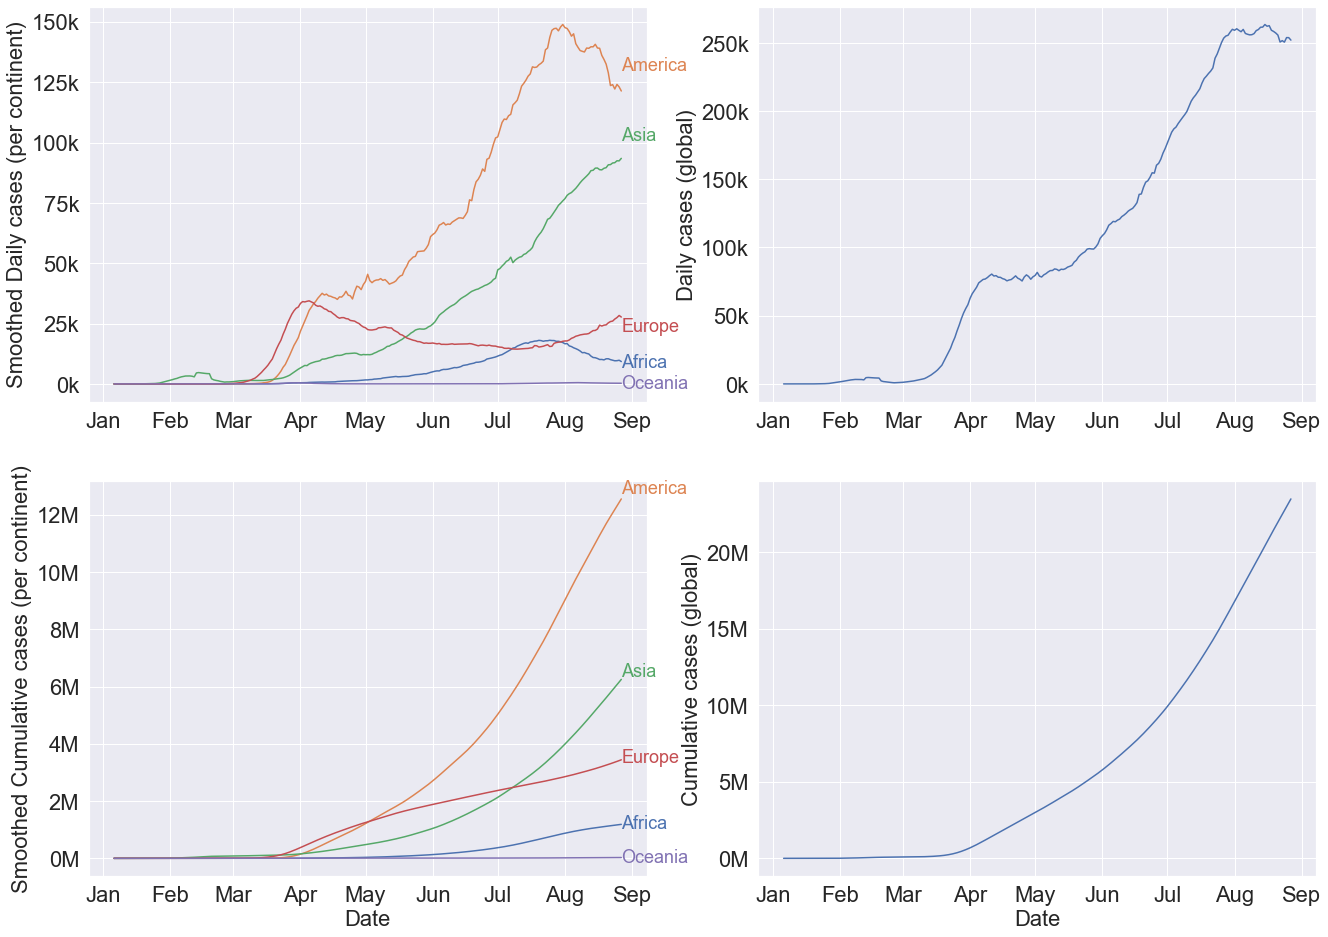

In [26]:
sns.set(rc={'figure.figsize':(22,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)
ax1 = sns.lineplot(x="DateRep", y="Moving_ave_cases", hue="Continent", data=smoothed_daily_cases, markers=True, legend=False, ax=axes[0, 0])
texts1 = [axes[0, 0].text(last_day_covid.loc[last_day_covid['Continent'] == str(continent)]['DateRep'], last_day_covid.loc[last_day_covid['Continent'] == str(continent)]['Cases'], str(continent), fontsize=18, color=ax1.get_lines()[continents.index(continent)].get_c(), ha = 'left', va = 'center') for continent in continents]
# adjust_text(texts)
axes[0, 0].set_ylabel("Smoothed Daily cases (per continent)",fontsize=22)
axes[0, 0].set_xlabel("",fontsize=22)
ax1.yaxis.set_major_formatter(formatter_kil)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(fmt)

ax2 = sns.lineplot(x="DateRep", y="Moving_ave_cases", hue="Continent", data=smoothed_cum_cases, markers=True, legend=False, ax=axes[1, 0])
texts2 = [axes[1, 0].text(last_day_covid_cumulative.loc[last_day_covid_cumulative['Continent'] == str(continent)]['DateRep'], last_day_covid_cumulative.loc[last_day_covid_cumulative['Continent'] == str(continent)]['Cases'], str(continent), fontsize=18, color=ax2.get_lines()[continents.index(continent)].get_c(), ha = 'left', va = 'center') for continent in continents]
axes[1, 0].set_ylabel("Smoothed Cumulative cases (per continent)",fontsize=22)
axes[1, 0].set_xlabel("Date",fontsize=22)
ax2.yaxis.set_major_formatter(formatter_mil)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(fmt)

ax3 = sns.lineplot(x="DateRep", y="Moving_ave_cases", data=covid_daily_global, markers=True, legend=False, ax=axes[0, 1]) 
axes[0, 1].set_ylabel("Daily cases (global)",fontsize=22)
axes[0, 1].set_xlabel("",fontsize=22)
ax3.yaxis.set_major_formatter(formatter_kil)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(fmt)

ax4 = sns.lineplot(x="DateRep", y="Moving_ave_cases", data=covid_daily_global_cumulative, markers=True, legend=False, ax=axes[1, 1]) 
axes[1, 1].set_ylabel("Cumulative cases (global)",fontsize=22)
axes[1, 1].set_xlabel("Date",fontsize=22)
ax4.yaxis.set_major_formatter(formatter_mil)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(fmt)

plt.savefig('Fig_4_1_Song_Ziruo.png')

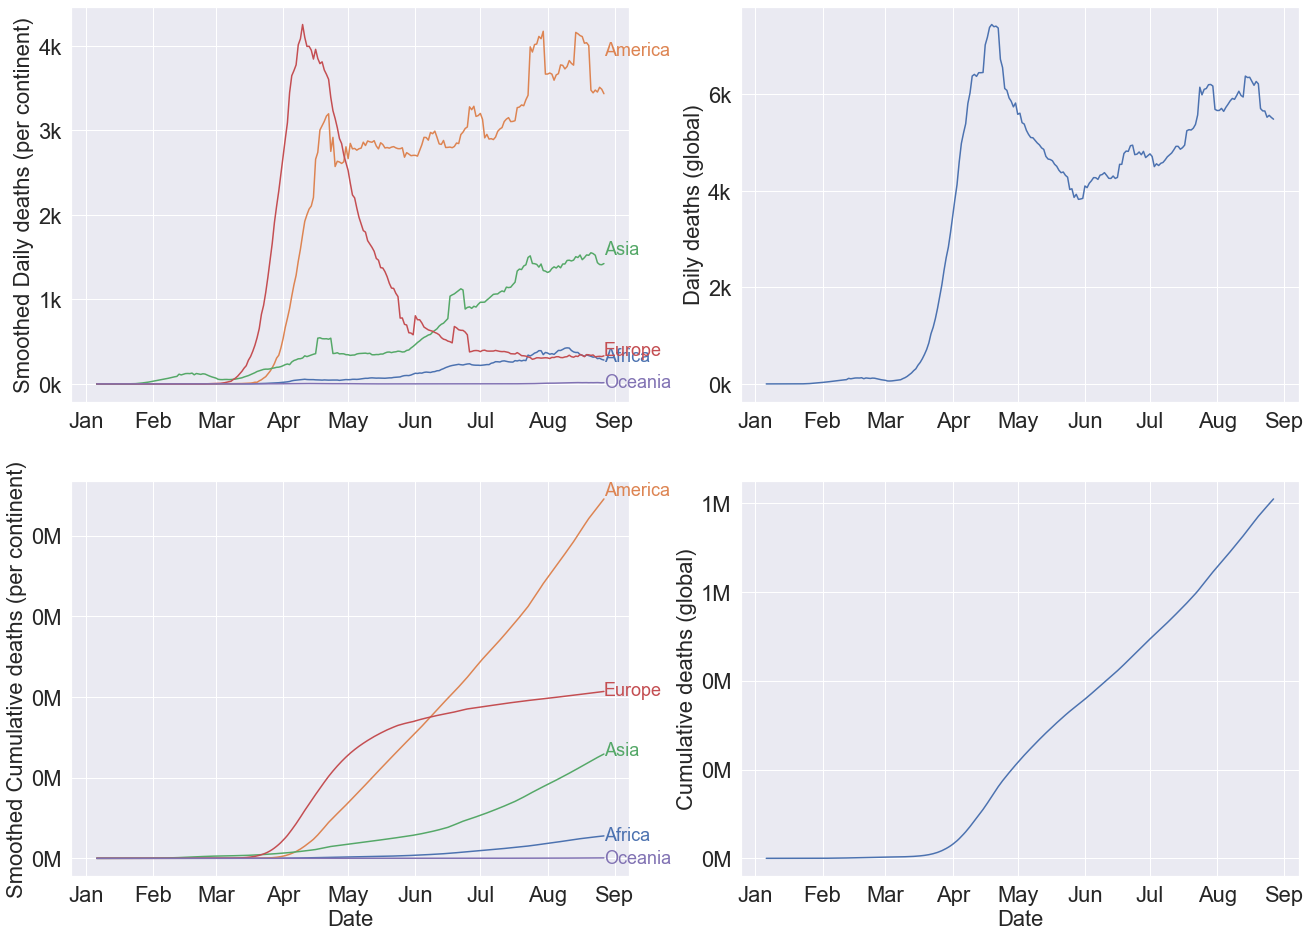

In [27]:
sns.set(rc={'figure.figsize':(22,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)
ax1 = sns.lineplot(x="DateRep", y="Moving_ave_deaths", hue="Continent", data=smoothed_daily_cases, markers=True, legend=False, ax=axes[0, 0]) #, hue_order=countries_1_5
texts1 = [axes[0, 0].text(last_day_covid.loc[last_day_covid['Continent'] == str(continent)]['DateRep'], last_day_covid.loc[last_day_covid['Continent'] == str(continent)]['Deaths'], str(continent), fontsize=18, color=ax1.get_lines()[continents.index(continent)].get_c(), ha = 'left', va = 'center') for continent in continents]
# adjust_text(texts)
axes[0, 0].set_ylabel("Smoothed Daily deaths (per continent)",fontsize=22)
axes[0, 0].set_xlabel("",fontsize=22)
ax1.yaxis.set_major_formatter(formatter_kil)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(fmt)

ax2 = sns.lineplot(x="DateRep", y="Moving_ave_deaths", hue="Continent", data=smoothed_cum_cases, markers=True, legend=False, ax=axes[1, 0]) #, hue_order=countries_1_5
texts2 = [axes[1, 0].text(last_day_covid_cumulative.loc[last_day_covid_cumulative['Continent'] == str(continent)]['DateRep'], last_day_covid_cumulative.loc[last_day_covid_cumulative['Continent'] == str(continent)]['Deaths'], str(continent), fontsize=18, color=ax2.get_lines()[continents.index(continent)].get_c(), ha = 'left', va = 'center') for continent in continents]
axes[1, 0].set_ylabel("Smoothed Cumulative deaths (per continent)",fontsize=22)
axes[1, 0].set_xlabel("Date",fontsize=22)
ax2.yaxis.set_major_formatter(formatter_mil)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(fmt)

ax3 = sns.lineplot(x="DateRep", y="Moving_ave_deaths", data=covid_daily_global, markers=True, legend=False, ax=axes[0, 1]) 
axes[0, 1].set_ylabel("Daily deaths (global)",fontsize=22)
axes[0, 1].set_xlabel("",fontsize=22)
ax3.yaxis.set_major_formatter(formatter_kil)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(fmt)

ax4 = sns.lineplot(x="DateRep", y="Moving_ave_deaths", data=covid_daily_global_cumulative, markers=True, legend=False, ax=axes[1, 1]) 
axes[1, 1].set_ylabel("Cumulative deaths (global)",fontsize=22)
axes[1, 1].set_xlabel("Date",fontsize=22)
ax4.yaxis.set_major_formatter(formatter_mil)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(fmt)

plt.savefig('Fig_4_2_Song_Ziruo.png')